<h1>Installing RDKit</h1>

In [39]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

optimizer = tf.keras.optimizers.Adam(0.001)
# optimizer = tf.keras.optimizers.Adagrad(0.003)

In [3]:
rdkit.__version__

'2021.03.5'

In [4]:
dc.__version__

'2.5.0'

In [5]:
np.__version__

'1.19.5'

In [6]:
tf.__version__

'2.6.0'

In [7]:
parameter_df = pd.read_csv('molecule_parameters.csv')
parameter_df.dropna(how='any', inplace=True)

In [8]:
ddg_df = pd.read_excel('refined_set_info.xlsx')

In [9]:
ddg_df.head()

,ID,PDB code,Subset,Complex Type,Resolution,Affinity Data,pKd pKi pIC50,kd/ki,ddg_cal_mol,ddg,...,Exact Mass,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,Canonical SMILES
0,1,10gs,refined,Protein-Ligand,2.2,Ki=0.4uM,6.40,3.981072e-07,-8.841927,-0.008842,...,474.170,61,62,185.74,0.82,1.60,3,6,13,O=C(N[C@H](C(=O)N[C@H](c1ccccc1)C(=O)O)CSCc1cc...
1,2,184l,refined,Protein-Ligand,1.8,Kd=19uM,4.72,1.905461e-05,-6.520921,-0.006521,...,134.110,24,24,0.00,3.51,2.89,0,0,2,CC(Cc1ccccc1)C
2,3,185l,refined,Protein-Ligand,1.8,Kd=290uM,3.54,2.884032e-04,-4.890691,-0.004891,...,117.058,16,17,15.79,2.05,2.17,1,0,0,c1ccc2c(c1)[nH]cc2
3,4,186l,refined,Protein-Ligand,1.8,Kd=14uM,4.85,1.412538e-05,-6.700523,-0.006701,...,134.110,24,24,0.00,3.80,3.03,0,0,3,CCCCc1ccccc1
4,5,187l,refined,Protein-Ligand,1.8,Kd=422uM,3.37,4.265795e-04,-4.655827,-0.004656,...,106.078,18,18,0.00,2.65,2.30,0,0,0,Cc1ccc(cc1)C


In [10]:
ddg_df[['affinity_unit_type','affinity']] =  ddg_df['Affinity Data'].str.split('=',expand=True)
# ddg_df['affinity']= ddg_df['affinity'].str.strip[-2]

In [11]:
ddg_df['affinity_unit']= ddg_df['affinity'].str[-2:]

In [12]:
ddg_df['affinity'] = ddg_df['affinity'].str[:-2].astype(float)

In [13]:
# ddg_df = ddg_df[ddg_df.affinity_unit_type == 'Kd']

In [14]:
len(ddg_df)

5316

In [15]:
ddg_df.rename(columns={'PDB code': 'complex-name'}, inplace=True)
df = pd.merge(parameter_df, ddg_df[['complex-name', 'ddg']], on='complex-name')

In [16]:
len(df)

192

In [17]:
np.std(df.ddg)

4.793622663650212

In [18]:
df.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,pb-protein-eelec,pb-protein-epb,pb-protein-ecavity,pb-ligand-etot,pb-ligand-vdwaals,pb-ligand-eelec,pb-ligand-epb,pb-ligand-ecavity,enthalpy,ddg
0,10gs,-16145.9190,18478.8142,-31052.1742,-3659.4630,86.9041,-16042.9095,18034.9833,-30493.1722,-3672.7126,...,-30493.1722,-3650.6491,87.9920,-565.1881,-10.1928,-416.8647,-141.8681,3.7375,-49.2158,-0.008842
1,1a1e,-9777.1684,7030.7012,-13515.0036,-3349.3791,56.5130,-9499.3955,7189.5223,-13366.9577,-3378.1703,...,-13366.9577,-3333.0961,56.2103,-173.5190,-11.4008,-96.6715,-69.9064,4.4598,8.7010,-0.008289
2,1a30,-6925.5462,9349.4510,-14111.7670,-2211.3839,48.1538,-6881.3365,8949.8465,-13675.6929,-2204.7807,...,-13675.6929,-2179.8309,49.2906,-645.4443,-9.3186,-381.1129,-257.9893,2.9765,167.0065,-0.005941
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,-60991.3946,-8730.0602,201.0222,-27.4572,-6.0182,74.3491,-99.2366,3.4485,-33.5445,-0.011052
4,1a4r,-14436.7381,16726.9825,-26744.9283,-4516.3615,97.5691,-13647.6149,18021.0326,-27237.1053,-4529.6519,...,-27237.1053,-4478.1330,98.1097,486.8763,-5.8718,583.2385,-93.5441,3.0538,-35.7125,-0.009201


In [19]:
# ddg = enthalpy - entropy
# entropy = enthalpy - ddg
# dh complex - (dh p + dh L)
# 
df['entropy'] = df.enthalpy - df.ddg
df.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,pb-protein-epb,pb-protein-ecavity,pb-ligand-etot,pb-ligand-vdwaals,pb-ligand-eelec,pb-ligand-epb,pb-ligand-ecavity,enthalpy,ddg,entropy
0,10gs,-16145.9190,18478.8142,-31052.1742,-3659.4630,86.9041,-16042.9095,18034.9833,-30493.1722,-3672.7126,...,-3650.6491,87.9920,-565.1881,-10.1928,-416.8647,-141.8681,3.7375,-49.2158,-0.008842,-49.206958
1,1a1e,-9777.1684,7030.7012,-13515.0036,-3349.3791,56.5130,-9499.3955,7189.5223,-13366.9577,-3378.1703,...,-3333.0961,56.2103,-173.5190,-11.4008,-96.6715,-69.9064,4.4598,8.7010,-0.008289,8.709289
2,1a30,-6925.5462,9349.4510,-14111.7670,-2211.3839,48.1538,-6881.3365,8949.8465,-13675.6929,-2204.7807,...,-2179.8309,49.2906,-645.4443,-9.3186,-381.1129,-257.9893,2.9765,167.0065,-0.005941,167.012441
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,-8730.0602,201.0222,-27.4572,-6.0182,74.3491,-99.2366,3.4485,-33.5445,-0.011052,-33.533448
4,1a4r,-14436.7381,16726.9825,-26744.9283,-4516.3615,97.5691,-13647.6149,18021.0326,-27237.1053,-4529.6519,...,-4478.1330,98.1097,486.8763,-5.8718,583.2385,-93.5441,3.0538,-35.7125,-0.009201,-35.703299


<h1>Reading Mobley PDB files</h1>
<p>Here each PDB file will be read and saved in Mol data type defined in RDKit and used by DeepChem</p>

In [20]:
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
# mypath = '../../../../../../Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/pdbbind/raw-data/'
mypath = '../dataset/'
onlyfiles = [f for f in listdir(mypath) if f not in ('.DS_Store') and f in (df['complex-name'].tolist())]
for f in onlyfiles:
    print(f)
    PDBs.update({f: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + f + '/com_new.pqr')})

for key, value in dict(PDBs).items():
    if value is None:
        del PDBs[key]
        

1bai
1bdq
1bnv
1a1e
1bnq
1bn4
1bn3
1bhf
1c87
1c1r
1bgq
1c1u
1c86
1c88
1a4r
1bnw
1ai4
1b6l
1ajp
1b6k
1d3d
1bp0
1b5j
1ceb
1aid
1b3f
1b3h
1ciz
1ajx
1ajq
1b6j
1ajv
1ai5
1b0h
1b3g
1b52
1d3p
1b55
1add
1amw
1b46
1b4z
1b4h
1adl
1b40
1d4l
1cbx
1d4k
1b8y
1d7j
1b7h
1d4p
1bq4
1bwa
1d4y
1c5n
1bcd
1c5s
1a99
1c3x
1a30
1c5o
1bjv
1ax0
1a4w
1bnu
1c84
1ctt
1c70
1c83
1atl
1a4k
1bnn
1bma
1dgm
1dhi
1c4u
1bn1
1ctu
1bm7
1bnt
1bhx
1b57
1d9i
1b3l
1b32
1b6h
1ai7
1bzc
1cet
1d6v
1b5i
1b58
1afk
1d09
1bv7
1afl
1bzy
1ajn
1alw
1bv9
1b51
1b05
1aj7
1d6w
1b5h
1b9j
1d2e
1b8n
1aaq
1cnx
1cgl
1bxr
1b1h
1bty
1br6
1b8o
1bwb
1cnw
1ado
1cny
1d7i
1b2h
1apv
1c5c
1bcu
1c5q
1df8
1c5x
1cps
1bju
1a9m
1avn
1det
1c5y
1a94
1a69
1c5p


In [36]:
len(PDBs)

138

In [21]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

<h1>Featurizing</h1>
<p>GraphConv model needs ConvMolFeaturizer</p>

In [30]:
# featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
# TRAIN_SET = .7
# VAL_SET = .3

In [22]:
# PDBs.pop('1dl7',None)

In [23]:
# PDBs.pop('',None)
# X = []
# X_ids = []
# # one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
# for k in PDBs.keys():
#     X_ids.append(k)
#     X.append(featurizer.featurize(PDBs[k]))
# train_split_index = int(len(X) * TRAIN_SET)
# val_split_index = int(len(X) * VAL_SET)
# X = [x[0] for x in X]
# X_train_featurized = X[:train_split_index]
# # X_val_featurized = X[train_split_index: (train_split_index + val_split_index)]
# X_val_featurized = X[train_split_index:]
# X_test_featurized = X[train_split_index:]

In [24]:
# host_names = [i.split('-')[0] for i in X_ids]
# guest_names = ['guest-' + (i.split('-')[1].replace('s', '')) for i in X_ids]

In [25]:
# # train
# host_names_train = host_names[:train_split_index]
# # guest_names_train = guest_names[:train_split_index]
# # Val
# # host_names_val = host_names[train_split_index:(train_split_index + val_split_index)]
# # guest_names_val = guest_names[train_split_index:(train_split_index + val_split_index)]
# host_names_val = host_names[train_split_index:]
# # guest_names_val = guest_names[train_split_index:]
# # test
# host_names_test = host_names[train_split_index:]
# # guest_names_test = guest_names[train_split_index:]


In [26]:
# x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
# # Train
# for i in range(len(host_names_train)):
#     new_df = df[(df['complex-name'] == host_names_train[i])]
#     y_train.append(new_df['ddg'].to_numpy()[0])
#     x_add_train.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c) and
#                                ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
# y_train = np.array(y_train)
# # Val
# for i in range(len(host_names_val)):
#     new_df = df[(df['complex-name'] == host_names_val[i])]
#     y_val.append(new_df['ddg'].to_numpy()[0])
#     x_add_val.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
#                          and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
# y_val = np.array(y_val)

# # Test
# for i in range(len(host_names_test)):
#     new_df = df[(df['complex-name'] == host_names_test[i])]
#     y_test.append(new_df['ddg'].to_numpy()[0])
#     x_add_test.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
#                          and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
# y_test = np.array(y_test)

In [27]:
# new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
#                          and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]]

,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,gb-protein-1-4-eel,gb-ligand-eelec,gb-ligand-egb,gb-ligand-esurf,gb-ligand-1-4-eel,pb-complex-vdwaals,pb-protein-vdwaals,pb-ligand-vdwaals,entropy
88,8547.7747,-14007.7907,-1761.2327,46.8828,8687.1978,-13913.7792,-1870.5974,48.7669,-139.4231,-27.7791,-53.7111,5.3962,-1835.2453,-1730.8651,-15.3497,-6.101588


In [28]:
# from deepchem.metrics import to_one_hot
# from deepchem.feat.mol_graphs import ConvMol

# x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []

# ## for X train
# multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
# x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
# for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
#     x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
# x_preprocessed_train.append(np.array(x_add_train))

# ## for X val
# multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
# x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
# for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
#     x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
# x_preprocessed_val.append(np.array(x_add_val))


# ## for X test
# multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
# x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
# for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
#     x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
# x_preprocessed_test.append(np.array(x_add_test))

In [29]:
# # Train
# x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
#                   np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)

# for i,j in enumerate(x_preprocessed_train):
#     if len(j.shape) > 1:
#         x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
#     else:
#         x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
# x_train = x_train.reshape([1] + list(x_train.shape))

# # Validation
# x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
#                   np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
# for i,j in enumerate(x_preprocessed_val):
#     if len(j.shape) > 1:
#         x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
#     else:
#         x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
# x_val = x_val.reshape([1] + list(x_val.shape))

# # Test
# x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
#                   np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
# for i,j in enumerate(x_preprocessed_test):
#     if len(j.shape) > 1:
#         x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
#     else:
#         x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
# x_test = x_test.reshape([1] + list(x_test.shape))

<h1>Physics Guided Neural Network Model</h1>

In [67]:
pgnn_test_accuracy = []
pgnn_train_accuracy = []

In [68]:
# ## !!!!!!!! important
# ## !!!!!!!! important
# ## !!!!!!!! important
# ## !!!!!!!! important
# batch_size = int(len(host_names_train)/4)
# batch_size
# # batch_size=10

In [76]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class PGNN(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(PGNN, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool(max_degree=50)

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool(max_degree=50)

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([0.5, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
# hybrid_model = GBGraphConvModel(train_split_index)
# hybrid_model.compile(loss='mse', optimizer=optimizer)

<h1> Data Driven Model </h1>

In [70]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
# input_shapes = [i.shape for i in x_preprocessed_train]

In [71]:
# dd_test_accuracy = []
# dd_train_accuracy = []

In [72]:
# batch_size = int(len(host_names_train)/4)
# batch_size
# # batch_size=10

In [77]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class GBGraphConvModel(tf.keras.Model):
   
    def modify_graphgather(self, batch_size):
        self.readout.batch_size = batch_size
        self.batch_size = batch_size

    def __init__(self, batch_size):
        super(GBGraphConvModel, self).__init__()
        self.input_shapes = None
        self.batch_size = batch_size
        self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool(max_degree=50)

        self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool(max_degree=50)

        self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(1)
    #     self.dense3 = layers.Dense(1, 
    #          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
    #          bias_initializer=initializers.Zeros())

    def call(self, inputs):
        inputs = inputs[0]
        x = []
    #     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
    #                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
        for i in range(len(self.input_shapes)):
            x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
        for i in range(1, len(self.input_shapes)):
            x[i] = tf.cast(x[i], tf.int32)
        x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
        gc1_output = self.gc1(x)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + x[1:])

        gc2_output = self.gc2([gp1_output] + x[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + x[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + x[1:])

        model_var = self.dense2(readout_output)
    #     binding_affinity = tf.concat([model_var, x_add], axis=1)
        return model_var #self.dense3(binding_affinity)
# dd_model = GBGraphConvModel(train_split_index)
# dd_model.compile(loss='mse', optimizer=optimizer)

<h1> K-fold</h1>

In [78]:
k_fold = 3
k = k_fold
max_epoch = 100
TRAIN_SET_PERCENTAGE = 1-(1/k)
VAL_SET_PERCENTAGE = 1/k
PDBs.pop('',None)
host_names = [i.split('-')[0] for i in X_ids]
X = []
X_ids = []
for i in PDBs.keys():
    X_ids.append(i)
    X.append(featurizer.featurize(PDBs[i]))
TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)

# PGNN model variables
pgnn_train_losses = [[] for _ in range(k_fold)]
pgnn_val_losses = [[] for _ in range(k_fold)]
pgnn_rmse_train, pgnn_rmse_test = [], []

# Data Driven model variables
dd_train_losses = [[] for _ in range(k_fold)]
dd_val_losses = [[] for _ in range(k_fold)]
dd_rmse_train, dd_rmse_test, rmse_gbnsr6_ex, rmse_gb_pb = [], [], [], []

# Physics-based model variables
physics_based_rmse_train, physics_based_rmse_test, rmse_pbsa_ex = [], [], []
# gb_r_squared, pb_r_squared, pbgb_r_squared = [], [], []
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
for fold in range(k_fold):
    # fold=0 -> 0 * (0.25 * 72) = 0
    # fold=1 -> 1 * (0.25 * 72) = 18
    # fold=2 -> 2 * (0.25 * 72) = 36
    # fold=3 -> 3 * (0.25 *72) = 54
    X, X_ids, host_names_val,guest_names_val, host_names_test, guest_names_test = [], [], [], [], [], []
    host_names_train, guest_names_train, X_val_featurized, X_test_featurized, X_train_featurized  = [], [], [], [], []
    
    
    for k in PDBs.keys():
        X_ids.append(k)
        X.append(featurizer.featurize(PDBs[k]))
    TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)
    val_split_index_begin = int(fold * TEST_SIZE)
#     print(f"begin {val_split_index_begin}")
    val_split_index_end = int(val_split_index_begin) + int(TEST_SIZE)
#     print(f"end {val_split_index_end}")
    # validation
    host_names_val = host_names[val_split_index_begin:val_split_index_end]
#     guest_names_val = guest_names[val_split_index_begin:val_split_index_end]
    # Test set
    host_names_test = host_names[val_split_index_begin:val_split_index_end]
#     guest_names_test = guest_names[val_split_index_begin:val_split_index_end]
    # Train set
    host_names_train = [host_names[i] for i in range(len(host_names)) if i not in range(val_split_index_begin,val_split_index_end)]
#     guest_names_train = [guest_names[i] for i in range(len(guest_names)) if i not in range(val_split_index_begin,val_split_index_end)]

    X = [x[0] for x in X]
    
    X_val_featurized = X[val_split_index_begin : val_split_index_end]
    X_test_featurized = X[val_split_index_begin : val_split_index_end]
#     for i in range(val_split_index_begin,val_split_index_end):
#         X = X.pop(i)
    X_train_featurized = [X[i] for i in range(len(X)) if i not in range(val_split_index_begin, val_split_index_end)]
    
    ### Step
    
    x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
    # Train
    for i in range(len(host_names_train)):
        new_df = df[(df['complex-name'] == host_names_train[i])]
        y_train.append(new_df['ddg'].to_numpy()[0])
        x_add_train.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_train = np.array(y_train)
    # Val
    for i in range(len(host_names_val)):
        new_df = df[(df['complex-name'] == host_names_val[i])]
        y_val.append(new_df['ddg'].to_numpy()[0])
        x_add_val.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_val = np.array(y_val)

    # Test
    for i in range(len(host_names_test)):
        new_df = df[(df['complex-name'] == host_names_test[i])]
        y_test.append(new_df['ddg'].to_numpy()[0])
        x_add_test.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_test = np.array(y_test)
    
    x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []
    
    ## Step
    
    # for X train
    multiConvMol = ConvMol.agglomerate_mols(X_train_featurized, max_deg=50)
    x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_train.append(np.array(x_add_train))

    ## for X val
    multiConvMol = ConvMol.agglomerate_mols(X_val_featurized, max_deg=50)
    x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_val.append(np.array(x_add_val))


    ## for X test
    multiConvMol = ConvMol.agglomerate_mols(X_test_featurized, max_deg=50)
    x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_test.append(np.array(x_add_test))
    
    ### Step
    
    # Train
    x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
                      np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_train):
        if len(j.shape) > 1:
            x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_train = x_train.reshape([1] + list(x_train.shape))

    # Validation
    x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
                      np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_val):
        if len(j.shape) > 1:
            x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_val = x_val.reshape([1] + list(x_val.shape))

    # Test
    x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
                      np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_test):
        if len(j.shape) > 1:
            x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_test = x_test.reshape([1] + list(x_test.shape))
    
    # Variable initializations for models
    
    val_size = len(y_val)
    train_size = len(y_train)
    
    # PGNN Model
    batch_size = len(host_names_train)
    hybrid_model = PGNN(len(y_train))
    hybrid_model.compile(loss='mse', optimizer=optimizer)

    for epoch in range(max_epoch):
        hybrid_model.modify_graphgather(train_size)
        hybrid_model.input_shapes = [i.shape for i in x_preprocessed_train]
        loss = hybrid_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        pgnn_train_losses[fold].append(loss.history['loss'][0])
        hybrid_model.input_shapes = [i.shape for i in x_preprocessed_val]
        hybrid_model.modify_graphgather(val_size)
        pgnn_val_losses[fold].append(hybrid_model.evaluate(x_val, y_val.reshape([1, -1])))
        
    hybrid_model.input_shapes = [i.shape for i in x_preprocessed_test]
    hybrid_model.modify_graphgather(len(y_test))
    evalu = hybrid_model.evaluate(x_test, y_test.reshape([1, -1]))
    # PGNN Testing RMSE calculation
    pgnn_rmse_test.append(np.sqrt(evalu))
    print(pgnn_rmse_test)
    # PGNN Training RMSE calculation
    train_loss = pgnn_train_losses[fold][-1]
    pgnn_rmse_train.append(math.sqrt(train_loss))
    
    # Data Driven model
    dd_model = GBGraphConvModel(len(y_train))
    dd_model.compile(loss='mse', optimizer=optimizer)
    
    for epoch in range(max_epoch):
        dd_model.modify_graphgather(train_size)
        dd_model.input_shapes = [i.shape for i in x_preprocessed_train]
        loss = dd_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        dd_train_losses[fold].append(loss.history['loss'][0])
        dd_model.input_shapes = [i.shape for i in x_preprocessed_val]
        dd_model.modify_graphgather(val_size)
        dd_val_losses[fold].append(dd_model.evaluate(x_val, y_val.reshape([1, -1])))
    
    dd_model.input_shapes = [i.shape for i in x_preprocessed_test]
    dd_model.modify_graphgather(len(y_test))
    dd_evaluate = dd_model.evaluate(x_test, y_test.reshape([1, -1]))
    # Data Driven Testing RMSE calculation
    dd_rmse_test.append(np.sqrt(dd_evaluate))
    print(dd_rmse_test)
    # Data Driven training RMSE calculation
    dd_train_loss = dd_train_losses[fold][-1]
    dd_rmse_train.append(math.sqrt(dd_train_loss))
    

ValueError: operands could not be broadcast together with shapes (51,) (11,) (51,) 

In [ ]:
# chekcing the wights after training for model with 50 nearest atom
hybrid_model.layers[-1].get_weights()

In [46]:
# chekcing the wights after training for model with 10 nearest atom
hybrid_model.layers[-1].get_weights()

[array([[ 0.49174324],
        [ 1.0007188 ],
        [ 1.0004653 ],
        [ 0.99951404],
        [ 0.99925315],
        [-0.99928445],
        [-0.99961   ],
        [-1.000125  ],
        [-1.0007284 ],
        [-0.999278  ],
        [-1.0047897 ],
        [-0.9893676 ],
        [-0.99743307],
        [ 1.000846  ],
        [-0.99912536],
        [-1.0005816 ],
        [-0.8383171 ]], dtype=float32),
 array([0.0039183], dtype=float32)]

<h1> Data Driven model evaluation </h1>

<h3>50 nearest neigbor atoms </h3>

In [ ]:
import matplotlib.pyplot as plt
average_dd_train_losses = [sum(x)/len(x) for x in zip(*dd_train_losses)]
average_dd_val_losses = [sum(x)/len(x) for x in zip(*dd_val_losses)]
# f, ax = plt.subplots()
plt.figure(figsize=(7,5))
plt.plot(range(len(average_dd_train_losses)), average_dd_train_losses, label='train loss')
plt.plot(range(len(average_dd_val_losses)), average_dd_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.savefig('ind_loss.png')

<h3>10 neighbor atoms </h3?

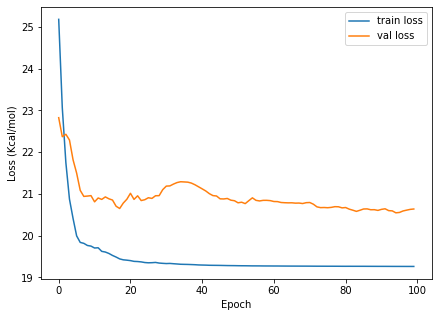

In [49]:
import matplotlib.pyplot as plt
average_dd_train_losses = [sum(x)/len(x) for x in zip(*dd_train_losses)]
average_dd_val_losses = [sum(x)/len(x) for x in zip(*dd_val_losses)]
# f, ax = plt.subplots()
plt.figure(figsize=(7,5))
plt.plot(range(len(average_dd_train_losses)), average_dd_train_losses, label='train loss')
plt.plot(range(len(average_dd_val_losses)), average_dd_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.savefig('ind_loss.png')

<h1> PGNN model evaludation</h1>

<h3> 50 nearest atom</h3>

In [ ]:
import matplotlib.pyplot as plt
average_pgnn_train_losses = [sum(x)/len(x) for x in zip(*pgnn_train_losses)]
average_pgnn_val_losses = [sum(x)/len(x) for x in zip(*pgnn_val_losses)]
# f, ax = plt.subplots()
plt.figure(figsize=(7,5))
plt.plot(range(len(average_pgnn_train_losses)), average_pgnn_train_losses, label='train loss')
plt.plot(range(len(average_pgnn_val_losses)), average_pgnn_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.savefig('comb_loss.png')

<h3> 10 neighbor atoms</h3>

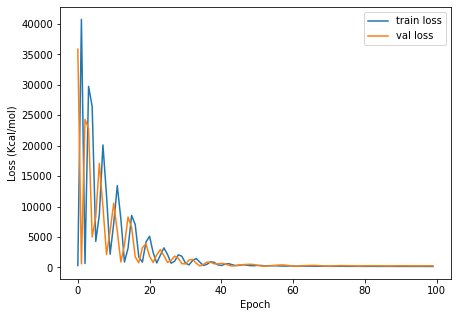

In [51]:
import matplotlib.pyplot as plt
average_pgnn_train_losses = [sum(x)/len(x) for x in zip(*pgnn_train_losses)]
average_pgnn_val_losses = [sum(x)/len(x) for x in zip(*pgnn_val_losses)]
# f, ax = plt.subplots()
plt.figure(figsize=(7,5))
plt.plot(range(len(average_pgnn_train_losses)), average_pgnn_train_losses, label='train loss')
plt.plot(range(len(average_pgnn_val_losses)), average_pgnn_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.savefig('comb_loss.png')

<h1> Physics based model RMSE </h1>

In [103]:
# import math
# train_sum=0
# for i in range(len(host_names_train)):
#     new_df = df[(df['complex-name'] == host_names_train[i])]
#     train_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2


# test_sum = 0
# for i in range(len(host_names_test)):
#     new_df = df[(df['complex-name'] == host_names_test[i])]
#     test_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2
    

In [ ]:
# physics_based_rmse_train = math.sqrt(train_sum / len(host_names_train))

In [ ]:
# physics_based_rmse_test = math.sqrt((test_sum) / len(host_names_test))

In [ ]:
# print(f"RMSE on training set is : {physics_based_rmse_train}")
# print(f"RMSE on testing set is : {physics_based_rmse_test}")
# # Total rmse
# total_rmse_physics = np.sqrt(np.mean((df['EX _H_(kcal/mol)'].to_numpy() - df['gb_delta_H'].to_numpy())**2))
# print(f"RMSE of the total data: {total_rmse_physics}")

In [ ]:
# # RMSE gbnsr6 vs experimental
# from sklearn.metrics import mean_squared_error
# import math
# mse_gb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['gb_delta_H'])
# rmse_gbnsr6_ex = math.sqrt(mse_gb_ex)
# print(rmse_gbnsr6_ex)

In [ ]:
# # RMSE pbsa vs experimental
# mse_pb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['pb_delta_H'])
# rmse_pbsa_ex = math.sqrt(mse_pb_ex)
# print(rmse_pbsa_ex)

In [ ]:
# # RMSE gbnsr6 vs pbsa
# mse_gb_pb = mean_squared_error(df['pb_delta_H'], df['gb_delta_H'])
# rmse_gb_pb = math.sqrt(mse_gb_pb)
# print(rmse_gb_pb)

In [ ]:
# import matplotlib.pyplot as plt

# plt.title("Experimental vs GBNSR6")
# plt.scatter(x=df['EX _H_(kcal/mol)'], y=df['gb_delta_H'])
# plt.xlabel("Experimental Delta H")
# plt.ylabel("GBNSR6 Delta H")
# plt.xlim(-25, 5)
# plt.ylim(-25,5)

# #reference line
# plt.plot([-25, 5], [-25, 5], color='green', lw=1)

In [ ]:
# plt.title("Experimental vs PBSA")
# plt.scatter(x=df['EX _H_(kcal/mol)'] ,y=df['pb_delta_H'], color='orange')
# plt.xlabel("Experimental Delta H")
# plt.ylabel("PBSA Delta H")
# plt.xlim(-25, 5)
# plt.ylim(-25,5)
# #reference line
# plt.plot([-25,5],[-25,5], color='green')

In [ ]:
# ax = plt.subplot()
# # plt.title("PBSA vs GBNSR6")
# plt.xlabel('Experimental ∆H (kcal/mol)')
# plt.ylabel('Physics-based model ∆H (kcal/mol)')
# ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['gb_delta_H'], label="GBNSR6")
# ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['pb_delta_H'], label="PBSA", color="orange")
# plt.xlim(-25,5)
# plt.ylim(-25,5)
# #reference line
# plt.plot([-25,5],[-25,5],color='green')
# plt.legend()
# plt.savefig('gb-pb.png')

In [ ]:
# gb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['EX _H_(kcal/mol)'])
# gb_correlation_gbex = gb_correlation_matrix[0,1]
# gb_r_squared = gb_correlation_gbex**2
# print(gb_r_squared)

In [ ]:
# pb_correlation_matrix = np.corrcoef(df['pb_delta_H'], df['EX _H_(kcal/mol)'])
# pb_correlation_pbex = pb_correlation_matrix[0,1]
# pb_r_squared = pb_correlation_pbex**2
# print(pb_r_squared)

In [ ]:
# pbgb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['pb_delta_H'])
# pbgb_correlation = pbgb_correlation_matrix[0,1]
# pbgb_r_squared = pbgb_correlation**2
# print(pbgb_r_squared)

In [52]:
# dd_losses, dd_val_losses = [], []
# max_epoch = 100
# val_size = len(y_val)
# train_size = len(y_train)

# for epoch in range(max_epoch):
#     dd_model.modify_graphgather(train_size)
#     dd_model.input_shapes = [i.shape for i in x_preprocessed_train]
#     loss = dd_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
# #     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
#     dd_losses.append(loss.history['loss'])
#     dd_model.input_shapes = [i.shape for i in x_preprocessed_val]
#     dd_model.modify_graphgather(val_size)
#     dd_val_losses.append(dd_model.evaluate(x_val, y_val.reshape([1, -1])))

In [53]:
# import matplotlib.pyplot as plt
# # f, ax = plt.subplots()
# plt.plot(range(len(dd_losses)), dd_losses, label='train loss')
# plt.plot(range(len(dd_val_losses)), dd_val_losses, label='val loss')
# plt.legend(loc='upper right');
# plt.xlabel("Epoch")
# plt.ylabel("Loss (Kcal/mol)")
# # plt.ylim(0,100)
# # plt.savefig('ind_loss.png')

In [54]:
# dd_model.input_shapes = [i.shape for i in x_preprocessed_test]
# # dd_model.modify_graphgather(len(y_test))
# test_pgnn_loss = dd_model.evaluate(x_test, y_test.reshape([1, -1]))

In [55]:
# dd_rmse_test = np.sqrt(test_pgnn_loss)
# print(dd_rmse_test)

In [56]:
# dd_train_loss = dd_losses[-1]
# dd_train_loss

In [57]:
# import math
# train_dd_rmse = math.sqrt(dd_train_loss[0])
# train_dd_rmse

In [58]:
# dd_test_accuracy.append(dd_rmse_test)
# dd_train_accuracy.append(train_dd_rmse)

In [59]:
# print(dd_test_accuracy)

In [61]:
dd_rmse_test


[4.6681060387760915, 4.3919293512662145, 4.5648544716174575]

<h1> Model Comparisons </h1>

In [63]:
# calculating the average RMSE on Training set
average_dd_rmse_train = sum(dd_rmse_train) / len(dd_rmse_train)
average_pgnn_rmse_train = sum(pgnn_rmse_train) / len(pgnn_rmse_train)
# average_physics_based_rmse_train = sum(physics_based_rmse_train) / len(physics_based_rmse_train)

from prettytable import PrettyTable
# Train
rmse_table = PrettyTable()
rmse_table.title="Train Set RMSE"
rmse_table.field_names = ["Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(average_dd_rmse_train),"{:.2f}".format(average_pgnn_rmse_train)])
print(rmse_table)

+---------------------+
|    Train Set RMSE   |
+-------------+-------+
| Data Driven |  PGNN |
+-------------+-------+
|     4.39    | 12.89 |
+-------------+-------+


In [66]:
# calculating the average RMSE on Testing set
average_dd_rmse_test = sum(dd_rmse_test) / len(dd_rmse_test)
average_pgnn_rmse_test = sum(pgnn_rmse_test) / len(pgnn_rmse_test)
# average_physics_based_rmse_test = sum(physics_based_rmse_test) / len(physics_based_rmse_test)

# Test
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Test Set RMSE"
rmse_table.field_names = ["Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(average_dd_rmse_test),"{:.2f}".format(average_pgnn_rmse_test)])
print(rmse_table)

+---------------------+
|    Test Set RMSE    |
+-------------+-------+
| Data Driven |  PGNN |
+-------------+-------+
|     4.54    | 16.49 |
+-------------+-------+


<h1> PGNN and DD model average performance analysis </h1>

In [119]:
# train_results_dict = {
#     "pgnn_train" : [x for x in pgnn_train_accuracy],
#     "dd_train" : [x for x in dd_train_accuracy]
# }
# test_results_dict ={
#     "pgnn_test" : [x for x in pgnn_test_accuracy],
#     "dd_test" : [x for x in dd_test_accuracy]
# }

In [224]:
# import matplotlib.pyplot as plt
# # Train box plot
# plt.figure(figsize=(10,12))
# plt.title("Train RMSE comparison")
# plt.boxplot([x for x in train_results_dict.values()],labels=[x for x in train_results_dict.keys()])
# plt.xlabel("PGNN and DD train")
# plt.ylabel("RMSE")
# plt.ylim(2, 5, 0.3)


In [223]:
# import matplotlib.pyplot as plt
# # Test box plot
# plt.figure(figsize=(10,12))
# plt.title("Test RMSE comparison")
# plt.boxplot([x for x in test_results_dict.values()],labels=[x for x in test_results_dict.keys()])
# plt.xlabel("PGNN and DD train")
# plt.ylabel("RMSE")
# plt.ylim(0, 8, 0.3)



<h1> Clustering based on ddg </h1>

<h2> k-mean clustering </h2>

In [124]:
# import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# from sklearn.cluster import KMeans

In [125]:
df.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,pb-protein-epb,pb-protein-ecavity,pb-ligand-etot,pb-ligand-vdwaals,pb-ligand-eelec,pb-ligand-epb,pb-ligand-ecavity,enthalpy,ddg,entropy
0,10gs,-16145.9190,18478.8142,-31052.1742,-3659.4630,86.9041,-16042.9095,18034.9833,-30493.1722,-3672.7126,...,-3650.6491,87.9920,-565.1881,-10.1928,-416.8647,-141.8681,3.7375,-49.2158,-0.008842,-49.206958
1,1a1e,-9777.1684,7030.7012,-13515.0036,-3349.3791,56.5130,-9499.3955,7189.5223,-13366.9577,-3378.1703,...,-3333.0961,56.2103,-173.5190,-11.4008,-96.6715,-69.9064,4.4598,8.7010,-0.008289,8.709289
2,1a30,-6925.5462,9349.4510,-14111.7670,-2211.3839,48.1538,-6881.3365,8949.8465,-13675.6929,-2204.7807,...,-2179.8309,49.2906,-645.4443,-9.3186,-381.1129,-257.9893,2.9765,167.0065,-0.005941,167.012441
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,-8730.0602,201.0222,-27.4572,-6.0182,74.3491,-99.2366,3.4485,-33.5445,-0.011052,-33.533448
4,1a4r,-14436.7381,16726.9825,-26744.9283,-4516.3615,97.5691,-13647.6149,18021.0326,-27237.1053,-4529.6519,...,-4478.1330,98.1097,486.8763,-5.8718,583.2385,-93.5441,3.0538,-35.7125,-0.009201,-35.703299


In [129]:
parameter_df.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,pb-protein-vdwaals,pb-protein-eelec,pb-protein-epb,pb-protein-ecavity,pb-ligand-etot,pb-ligand-vdwaals,pb-ligand-eelec,pb-ligand-epb,pb-ligand-ecavity,enthalpy
0,10gs,-16145.9190,18478.8142,-31052.1742,-3659.4630,86.9041,-16042.9095,18034.9833,-30493.1722,-3672.7126,...,-4077.8698,-30493.1722,-3650.6491,87.9920,-565.1881,-10.1928,-416.8647,-141.8681,3.7375,-49.2158
1,1a1e,-9777.1684,7030.7012,-13515.0036,-3349.3791,56.5130,-9499.3955,7189.5223,-13366.9577,-3378.1703,...,-1901.0486,-13366.9577,-3333.0961,56.2103,-173.5190,-11.4008,-96.6715,-69.9064,4.4598,8.7010
2,1a30,-6925.5462,9349.4510,-14111.7670,-2211.3839,48.1538,-6881.3365,8949.8465,-13675.6929,-2204.7807,...,-1777.0400,-13675.6929,-2179.8309,49.2906,-645.4443,-9.3186,-381.1129,-257.9893,2.9765,167.0065
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,-1084.3398,-60991.3946,-8730.0602,201.0222,-27.4572,-6.0182,74.3491,-99.2366,3.4485,-33.5445
4,1a4r,-14436.7381,16726.9825,-26744.9283,-4516.3615,97.5691,-13647.6149,18021.0326,-27237.1053,-4529.6519,...,-1733.7572,-27237.1053,-4478.1330,98.1097,486.8763,-5.8718,583.2385,-93.5441,3.0538,-35.7125


In [136]:
df_complete = pd.merge(parameter_df, ddg_df[['complex-name','Molecular Weight','Exact Mass','No. of atoms','No. of bonds'
                                    ,'Polar Surface Area','XLOGP3','open banel LogP','HB donor','HB acceptor',
                                    'Rotatable bonds','ddg']], on='complex-name')

In [137]:
df_complete.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,Exact Mass,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,ddg
0,10gs,-16145.9190,18478.8142,-31052.1742,-3659.4630,86.9041,-16042.9095,18034.9833,-30493.1722,-3672.7126,...,474.170,61,62,185.74,0.82,1.60,3,6,13,-0.008842
1,1a1e,-9777.1684,7030.7012,-13515.0036,-3349.3791,56.5130,-9499.3955,7189.5223,-13366.9577,-3378.1703,...,556.242,77,78,199.32,2.64,2.27,2,8,15,-0.008289
2,1a30,-6925.5462,9349.4510,-14111.7670,-2211.3839,48.1538,-6881.3365,8949.8465,-13675.6929,-2204.7807,...,376.172,52,51,197.74,0.20,-1.18,3,8,11,-0.005941
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,429.154,54,57,142.11,1.26,2.03,2,6,7,-0.011052
4,1a4r,-14436.7381,16726.9825,-26744.9283,-4516.3615,97.5691,-13647.6149,18021.0326,-27237.1053,-4529.6519,...,444.056,46,48,291.86,-5.89,-2.08,5,8,8,-0.009201


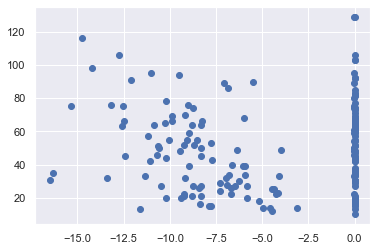

In [176]:
plt.scatter(df_complete['ddg'],df_complete['No. of atoms'])

In [177]:
conditions = [
    (df_complete['ddg'] > -1),
    (df_complete['ddg'] < -1) & (df_complete['ddg'] > -6),
    (df_complete['ddg'] < -6) & (df_complete['ddg'] >-11),
    (df_complete['ddg'] < -11)
]

values = ['1', '2', '3', '4']
df_complete['cluster'] = np.select(conditions, values)

df_complete.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,ddg,cluster
0,10gs,-16145.9190,18478.8142,-31052.1742,-3659.4630,86.9041,-16042.9095,18034.9833,-30493.1722,-3672.7126,...,61,62,185.74,0.82,1.60,3,6,13,-0.008842,1
1,1a1e,-9777.1684,7030.7012,-13515.0036,-3349.3791,56.5130,-9499.3955,7189.5223,-13366.9577,-3378.1703,...,77,78,199.32,2.64,2.27,2,8,15,-0.008289,1
2,1a30,-6925.5462,9349.4510,-14111.7670,-2211.3839,48.1538,-6881.3365,8949.8465,-13675.6929,-2204.7807,...,52,51,197.74,0.20,-1.18,3,8,11,-0.005941,1
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,54,57,142.11,1.26,2.03,2,6,7,-0.011052,1
4,1a4r,-14436.7381,16726.9825,-26744.9283,-4516.3615,97.5691,-13647.6149,18021.0326,-27237.1053,-4529.6519,...,46,48,291.86,-5.89,-2.08,5,8,8,-0.009201,1


In [283]:
from prettytable import PrettyTable
cluster_table = PrettyTable()
# cluster_table.title = "Clusters details"
# cluster_table = PrettyTable(["cluster", "Min", "Max", "count"])
cluster_table.add_column = ['cluster', 'Min', 'Max', 'count']

cluster_table.add_rows([
    ["1", str(min(df_complete[df_complete['cluster']=='1'].ddg)),
           str(max(df_complete[df_complete['cluster']=='1'].ddg)), str(len(df_complete[df_complete['cluster']=='1']))]
                     ,
                     ["2", str(min(df_complete[df_complete['cluster']=='2'].ddg)),
           str(max(df_complete[df_complete['cluster']=='2'].ddg)), str(len(df_complete[df_complete['cluster']=='2']))]
    ])

cluster_table.add_row([2, min(df_complete[df_complete['cluster']=='2'].ddg),
           max(df_complete[df_complete['cluster']=='2'].ddg), len(df_complete[df_complete['cluster']=='2'])])

print(cluster_table)


++
||
++



++


In [276]:
str(min(df_complete[df_complete['cluster']=='1'].ddg))

'-0.012433959502167847'

<h3> Feature correlation chart </h3>

<AxesSubplot:>

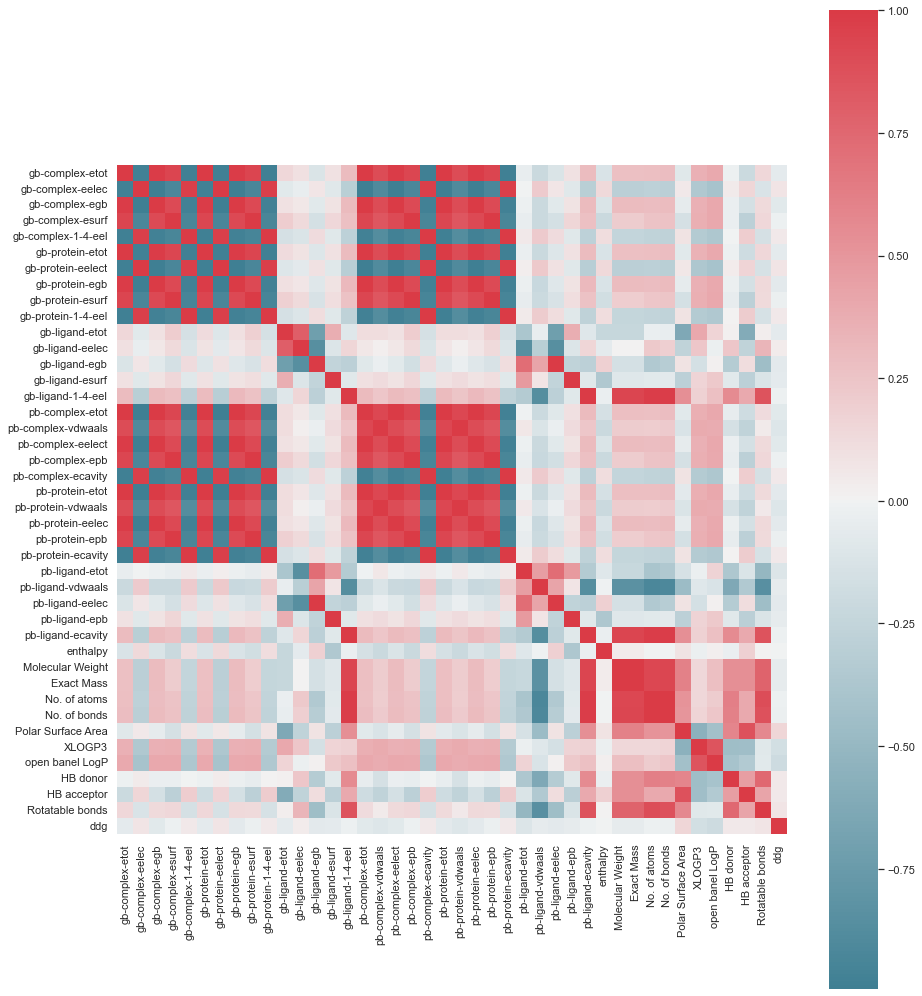

In [232]:
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 18))
corr = df_complete.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [262]:
df_complete = df_complete.sort_values('ddg')

In [266]:
df_complete.head()

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,ddg,cluster
121,1ctu,-20236.4479,27041.7752,-42512.4364,-4863.9564,98.1697,-20119.9307,27163.9385,-42478.2934,-4904.2201,...,31,32,122.49,-2.51,-2.45,5,5,6,-16.468089,4
148,1duv,-37695.7362,45365.9222,-72048.7476,-11175.3418,162.4310,-36933.0733,46295.0533,-72274.0054,-11116.9829,...,35,34,227.89,-4.67,0.33,4,6,6,-16.302302,4
129,1d4y,-7051.2872,8735.6997,-13829.0438,-2007.1271,49.1840,-7011.5117,8908.1869,-13850.0690,-2120.7722,...,75,78,113.97,6.97,8.48,2,5,12,-15.335217,4
140,1dif,-7189.5494,9057.3809,-14396.4571,-1898.9471,48.4739,-7132.0463,8729.7313,-13898.5516,-2013.9557,...,116,119,189.12,4.55,5.84,6,8,27,-14.727334,4
105,1c70,-6994.3118,8810.7851,-13802.5692,-2050.5160,47.9883,-7069.5106,8644.7789,-13707.9248,-2056.4769,...,98,103,120.68,4.30,5.30,6,4,16,-14.229976,4


In [270]:
df_complete[df_complete['cluster']=='1']

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,ddg,cluster
28,1apv,-9729.2469,16127.6347,-19940.8435,-5977.8115,61.7734,-9784.0160,15933.2141,-19691.0842,-6089.6200,...,80,79,156.86,2.58,2.47,6,6,20,-0.012434,1
10,1aaq,-6882.8585,9115.3337,-14166.5915,-1878.8070,47.2064,-6909.2116,8675.3234,-13675.7958,-1957.9994,...,89,89,190.57,1.79,1.01,6,6,22,-0.011605,1
3,1a4k,-29413.8956,40100.7078,-61088.2896,-8626.6708,200.3571,-29189.9201,40319.8406,-60991.3946,-8719.3884,...,54,57,142.11,1.26,2.03,2,6,7,-0.011052,1
25,1ajx,-7109.8141,8755.2302,-14014.2458,-1897.9794,47.1808,-7142.5274,8673.5864,-13861.7579,-2003.3651,...,74,78,82.47,4.73,4.62,2,3,12,-0.010928,1
7,1a94,-7065.4194,9405.5759,-14502.2577,-2016.7336,47.9960,-6979.1838,8857.9436,-13864.3605,-2022.6154,...,129,129,348.64,1.97,0.59,8,9,33,-0.010845,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1c3x,-28447.0897,30876.7837,-47753.7571,-11716.8414,146.7252,-28251.2517,31166.2296,-47827.3392,-11737.4440,...,16,17,100.45,-0.39,0.41,3,2,0,-0.000005,1
99,1c5o,-10253.2140,9294.1664,-16166.4804,-3441.5449,60.6449,-10179.9109,9366.7700,-16142.9047,-3464.8019,...,18,18,51.61,2.71,-0.15,0,0,1,-0.000005,1
90,1bxr,-44706.2980,40071.1927,-72663.8079,-12287.4370,173.7542,-43547.0963,42299.9263,-73299.2839,-12722.5307,...,51,53,332.18,-6.35,-2.40,4,12,9,-0.000005,1
64,1bcu,-10507.9532,9850.1029,-16804.4889,-3614.9180,61.3508,-10371.5958,10098.0947,-16831.4821,-3699.8624,...,27,29,64.93,2.17,3.71,2,1,0,-0.000005,1


In [271]:
df_complete[df_complete['cluster']=='2']

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,ddg,cluster
154,1e3v,-10809.8809,9172.4825,-16375.5717,-3668.9142,62.1225,-10826.6671,9214.8308,-16382.8681,-3721.3870,...,68,71,77.76,6.36,4.48,2,4,5,-5.995932,2
135,1det,-3951.1539,4621.0509,-6715.5879,-1884.6198,28.0030,-3567.0492,4984.1893,-6705.6963,-1873.3553,...,39,41,222.79,-3.99,-2.43,4,7,5,-5.940670,2
152,1e2l,-22966.9795,21831.6320,-39638.2999,-5272.6957,112.3841,-22816.9618,22027.1782,-39645.8057,-5311.3833,...,34,36,95.32,-0.47,-0.85,3,4,4,-5.926854,2
104,1c5y,-8334.7785,9853.2885,-15831.1983,-2409.3136,52.4449,-8235.4962,9934.2510,-15840.7108,-2381.9454,...,20,21,92.74,3.03,0.46,0,1,1,-5.802514,2
109,1c87,-12572.8989,12790.4262,-21226.8904,-4202.3520,65.9173,-12504.0850,12725.1306,-21032.7498,-4262.8163,...,27,28,141.17,2.60,0.62,1,5,2,-5.802514,2
156,1e5j,-11292.5294,14835.9285,-16134.0612,-10050.8011,56.4044,-11394.2859,14384.1038,-15725.9631,-10109.1591,...,90,93,368.97,-6.89,-7.66,13,13,24,-5.526204,2
190,1f5k,-8342.3441,9548.0309,-15558.9849,-2385.7448,54.3547,-8273.5665,9620.7760,-15600.4862,-2348.5824,...,18,18,51.61,2.71,-0.15,0,0,1,-5.167001,2
132,1d7i,-4215.5038,4540.3114,-7683.3865,-1102.4728,30.0441,-4196.5059,4560.5347,-7680.6113,-1106.7679,...,14,13,61.58,0.07,1.55,0,1,1,-4.973584,2
133,1d7j,-4255.6781,4499.2452,-7708.0541,-1076.7113,29.8421,-4217.2425,4574.0820,-7740.3415,-1081.1215,...,14,13,37.30,-0.80,-0.04,1,2,3,-4.559118,2
158,1e6s,-36303.8492,45124.3545,-69142.4352,-12453.9541,168.1856,-36337.1590,44910.5661,-68920.7790,-12495.5094,...,25,25,125.54,-1.80,-2.85,6,5,6,-4.448594,2


In [272]:
df_complete[df_complete['cluster']=='4']

,complex-name,gb-complex-etot,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-complex-1-4-eel,gb-protein-etot,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,...,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,ddg,cluster
121,1ctu,-20236.4479,27041.7752,-42512.4364,-4863.9564,98.1697,-20119.9307,27163.9385,-42478.2934,-4904.2201,...,31,32,122.49,-2.51,-2.45,5,5,6,-16.468089,4
148,1duv,-37695.7362,45365.9222,-72048.7476,-11175.3418,162.4310,-36933.0733,46295.0533,-72274.0054,-11116.9829,...,35,34,227.89,-4.67,0.33,4,6,6,-16.302302,4
129,1d4y,-7051.2872,8735.6997,-13829.0438,-2007.1271,49.1840,-7011.5117,8908.1869,-13850.0690,-2120.7722,...,75,78,113.97,6.97,8.48,2,5,12,-15.335217,4
140,1dif,-7189.5494,9057.3809,-14396.4571,-1898.9471,48.4739,-7132.0463,8729.7313,-13898.5516,-2013.9557,...,116,119,189.12,4.55,5.84,6,8,27,-14.727334,4
105,1c70,-6994.3118,8810.7851,-13802.5692,-2050.5160,47.9883,-7069.5106,8644.7789,-13707.9248,-2056.4769,...,98,103,120.68,4.30,5.30,6,4,16,-14.229976,4
136,1df8,-16866.7740,20245.8013,-33428.8442,-3775.5551,91.8240,-16749.7909,20337.2006,-33379.3248,-3800.0801,...,32,33,103.73,1.78,1.45,2,3,4,-13.401045,4
142,1dmp,-7047.7223,8515.6840,-13737.1491,-1872.9778,46.7206,-7026.6914,8541.4170,-13630.3146,-1986.2648,...,76,80,116.05,3.94,5.27,4,3,10,-13.193813,4
126,1d4k,-6988.6579,8661.7368,-13586.4777,-2111.5040,47.5870,-7003.1640,8383.4362,-13272.1788,-2164.3322,...,106,110,153.60,4.94,3.80,6,5,14,-12.737901,4
134,1d9i,-9935.6192,9331.8735,-15866.7595,-3460.2512,59.5179,-9755.6747,9488.1019,-15823.7999,-3479.9329,...,63,66,148.19,0.79,0.78,2,5,8,-12.585930,4
124,1d3d,-12452.1939,11679.4120,-20457.9537,-3738.4214,64.7692,-12482.2277,11662.4694,-20399.9311,-3810.6469,...,75,80,66.58,7.68,8.00,3,1,10,-12.558299,4
